**Sentiment Analysis with BERT**  
In this notebook, you'll learn how to fine-tune BERT for sentiment analysis. You'll do the required text preprocessing (special tokens, padding, and attention masks) and build a Sentiment Classifier using the amazing Transformers library by Hugging Face!

You'll learn how to:

Preprocess text data for BERT and build PyTorch Dataset (tokenization, attention masks, and padding)
Use Transfer Learning to build Sentiment Classifier using the Transformers library by Hugging Face
Evaluate the model on test data
Predict sentiment on raw text
Let's get started!

**What is BERT?**  
BERT (introduced in this paper) stands for Bidirectional Encoder Representations from Transformers. If you don't know what most of that means - you've come to the right place! Let's unpack the main ideas:

Bidirectional - to understand the text you're looking you'll have to look back (at the previous words) and forward (at the next words)
Transformers - The Attention Is All You Need paper presented the Transformer model. The Transformer reads entire sequences of tokens at once. In a sense, the model is non-directional, while LSTMs read sequentially (left-to-right or right-to-left). The attention mechanism allows for learning contextual relations between words (e.g. his in a sentence refers to Jim).
(Pre-trained) contextualized word embeddings - The ELMO paper introduced a way to encode words based on their meaning/context. Nails has multiple meanings - fingernails and metal nails.
BERT was trained by masking 15% of the tokens with the goal to guess them. An additional objective was to predict the next sentence. Let's look at examples of these tasks:

**Masked Language Modeling (Masked LM)**  
The objective of this task is to guess the masked tokens. Let's look at an example, and try to not make it harder than it has to be:

That's [mask] she [mask] -> That's what she said

**Next Sentence Prediction (NSP)**  
Given a pair of two sentences, the task is to say whether or not the second follows the first (binary classification). Let's continue with the example:

Input = [CLS] That's [mask] she [mask]. [SEP] Hahaha, nice! [SEP]

Label = IsNext

Input = [CLS] That's [mask] she [mask]. [SEP] Dwight, you ignorant [mask]! [SEP]

Label = NotNext

The training corpus was comprised of two entries: Toronto Book Corpus (800M words) and English Wikipedia (2,500M words). While the original Transformer has an encoder (for reading the input) and a decoder (that makes the prediction), BERT uses only the decoder.

BERT is simply a pre-trained stack of Transformer Encoders. How many Encoders? We have two versions - with 12 (BERT base) and 24 (BERT Large).

**Is This Thing Useful in Practice?**  
The BERT paper was released along with the source code and pre-trained models.

The best part is that you can do Transfer Learning (thanks to the ideas from OpenAI Transformer) with BERT for many NLP tasks - Classification, Question Answering, Entity Recognition, etc. You can train with small amounts of data and achieve great performance!

**Setup**  
We'll need the Transformers library by Hugging Face:

In [1]:
!pip install transformers==3

     |████████████████████████████████| 757kB 5.1MB/s 
     |████████████████████████████████| 3.0MB 17.0MB/s 
     |████████████████████████████████| 1.2MB 33.8MB/s 
     |████████████████████████████████| 901kB 30.4MB/s 


In [2]:
!pip install -q -U watermark
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.8.1+cu101
transformers: 3.0.0



In [3]:

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
pd.set_option('max_columns', None)

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict
from textwrap import wrap

import os

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cpu')

In [7]:
df = pd.read_csv('train_dataset_1 (1).csv')

In [8]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,151762,B00315WGNK,A3VRVNLY3CHX9B,"suziq ""suziq""",2,2,5,1260403200,"Be Careful this stuff is addictive, but at the...","Altho I did get a bite or two, I have to admit..."
1,421433,B0013N6YWG,A2F6CVR0M82NEY,"Matthew Paul ""Shark""",4,4,5,1306627200,FROMM SURF&TURF,My dogs love this stuff. I was currently on Ta...
2,442308,B0030HSFW0,A325MODT9B090,"Bilfurd ""bilfurd""",1,1,4,1330300800,Worked Well,Worked exactly as I needed for my first sausag...
3,358180,B0032CJPOK,ANFMXVT7RDJ7R,la mom,0,0,5,1278460800,not afraid of subscribe and save,We love Earth's Best products. This is the on...
4,541921,B000FKQD42,A3T385QBAHF49I,Jack,0,0,5,1193097600,Ginger and cinnamon together,"<a href=""http://www.amazon.com/gp/product/B000..."


In [9]:
df.shape

(200000, 10)

Lets continue working with df2. I will rename it to df for simplicity.

In [10]:
df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               3
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   5
Text                      0
dtype: int64

The task will be using the column Summary to predict Score

We will use the not null values only

In [11]:
df = df[df['Summary'].notnull() & df['Score'].notnull()]
df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               3
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [12]:
df = df[['Summary', 'Score']]
df.columns = ['Summary', 'Score']
df.shape

(199995, 2)

Text(0.5, 0, 'Rating Count')

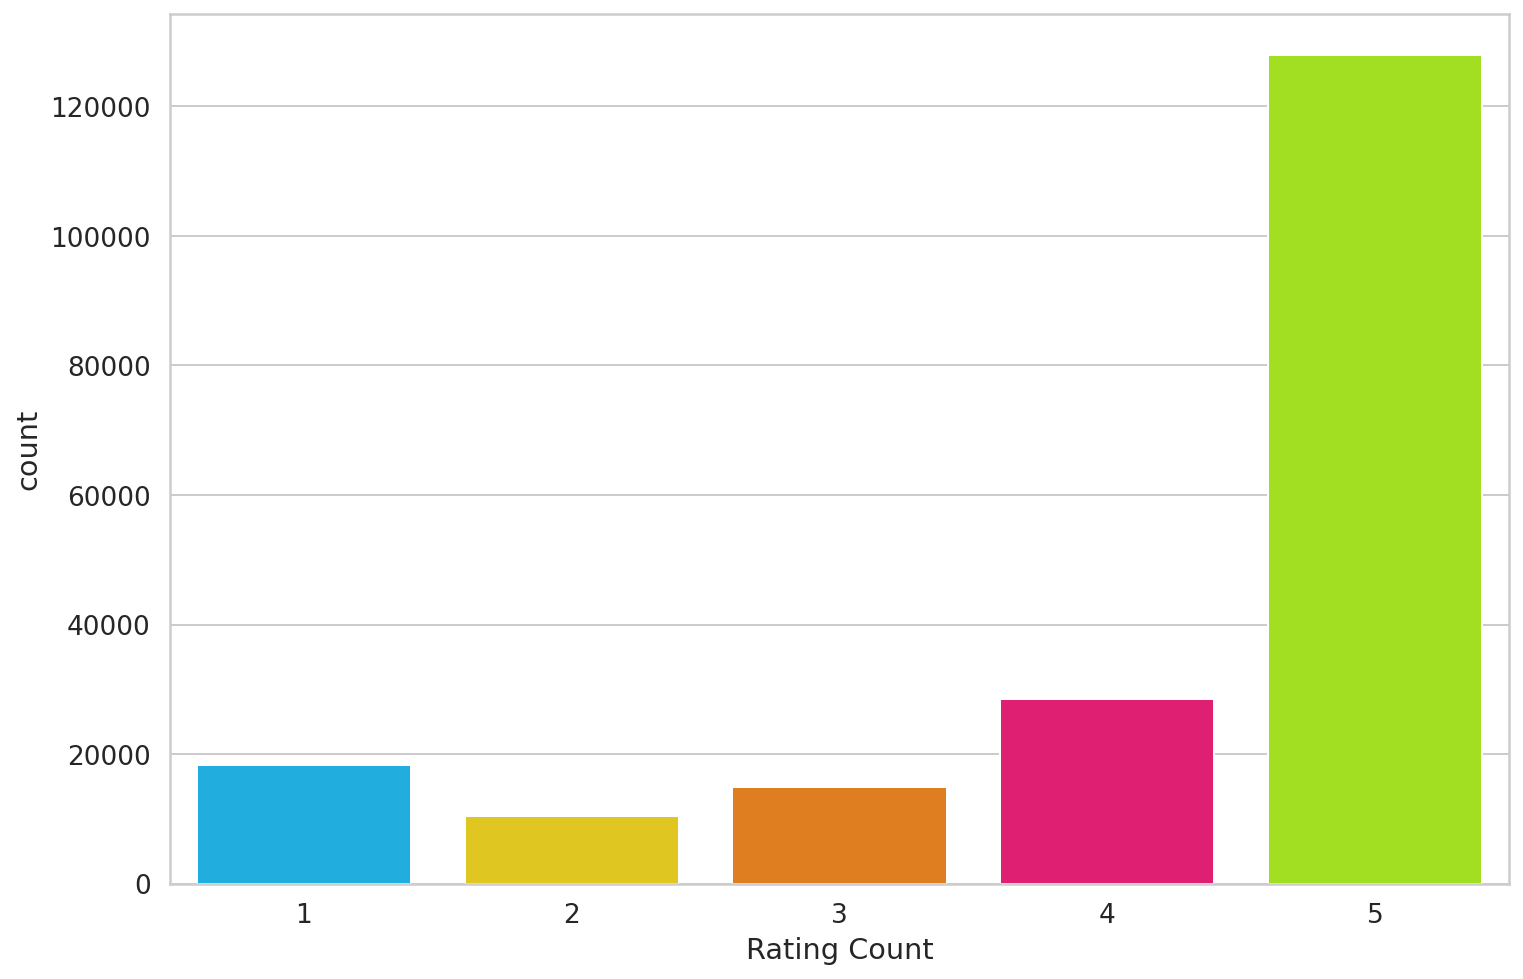

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(df['Score'])
plt.xlabel('Rating Count')

Now, I will combine the 1, 2, and 3 ratings in a class and keep the 4 and 5 classes as is. Lets call our new classes negative, neutral, and positive.

In [14]:
def to_sentiment(rating):
    """ Convert rating into sentiment"""
    if rating == 5:
        sentiment = 'positive'
    elif rating == 4:
        sentiment = 'neutral'
    else:
        sentiment = 'negative'
    return sentiment

In [15]:
df['sentiment'] = df['Score'].apply(to_sentiment)

In [16]:
df.head()

,Summary,Score,sentiment
0,"Be Careful this stuff is addictive, but at the...",5,positive
1,FROMM SURF&TURF,5,positive
2,Worked Well,4,neutral
3,not afraid of subscribe and save,5,positive
4,Ginger and cinnamon together,5,positive


(positive    63.951599
 negative    21.800545
 neutral     14.247856
 Name: sentiment, dtype: float64, 2)

Text(0.5, 0, 'Class Count')

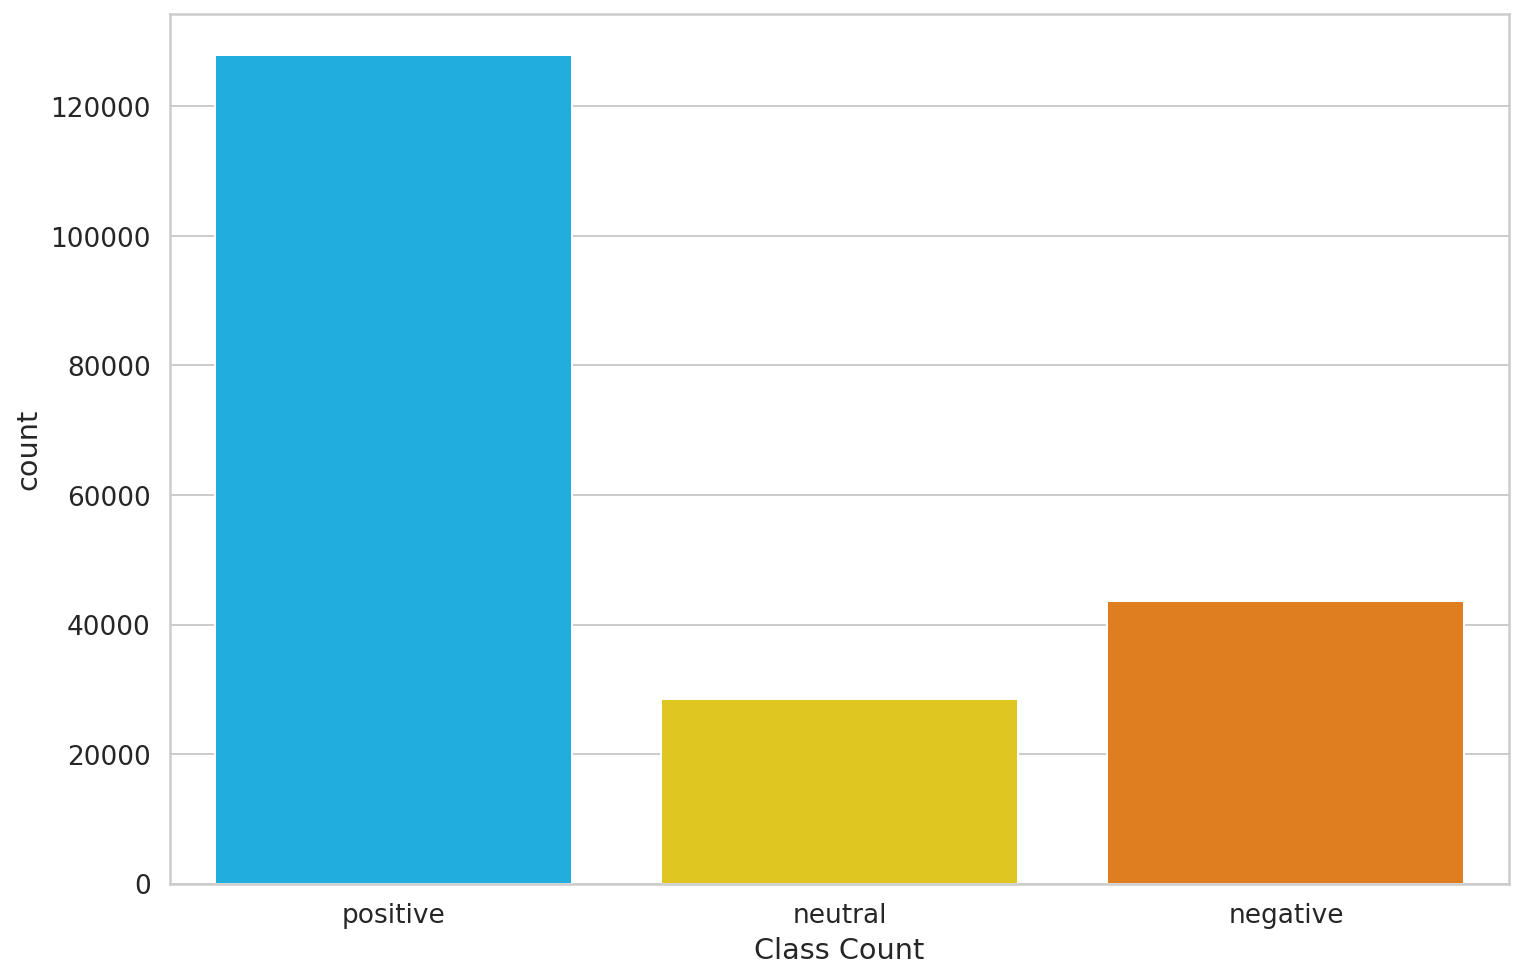

In [17]:
(df.sentiment.value_counts() *100 / len(df), 2)
sns.countplot(df.sentiment)
plt.xlabel('Class Count')

As we see, we have a huge imbalance and this will affect the model for sure but we will try to see how BERT will deal with this imblance.

**Data Preprocessing**  
We already know that Machine Learning models don't work with raw text. You need to convert text to numbers (of some sort). BERT requires even more attention:

1.   Add special tokens to separate sentences and do classification

2.   Pass sequences of constant length (introduce padding)

3.   Create array of 0s (pad token) and 1s (real token) called attention mask  

The Transformers library provides a wide variety of Transformer models (including BERT). It works with TensorFlow and PyTorch! It also includes prebuild tokenizers that do the heavy lifting for us!

In [18]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

You can use a cased and uncased version of BERT and tokenizer. I've experimented with both. The cased version works better. Intuitively, that makes sense, since "BAD" might convey more sentiment than "bad".

Let's load a pre-trained BertTokenizer:

In [19]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [20]:
sample_txt = 'Machine Learning is so much fun!! I love Machine Learning apps and practice it twice a week.'

In [21]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  truncation=True,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 32
The attention mask has the same length:

In [22]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,  7792,  9681,  1110,  1177,  1277,  4106,   106,   106,   146,
         1567,  7792,  9681, 23875,  1105,  2415,  1122,  3059,   170,  1989,
          119,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

In [23]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

Choosing Sequence Length  
BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [24]:
token_lens = []

for txt in df.Summary:
    tokens = tokenizer.encode(txt,truncation=True, max_length=512)
    token_lens.append(len(tokens))

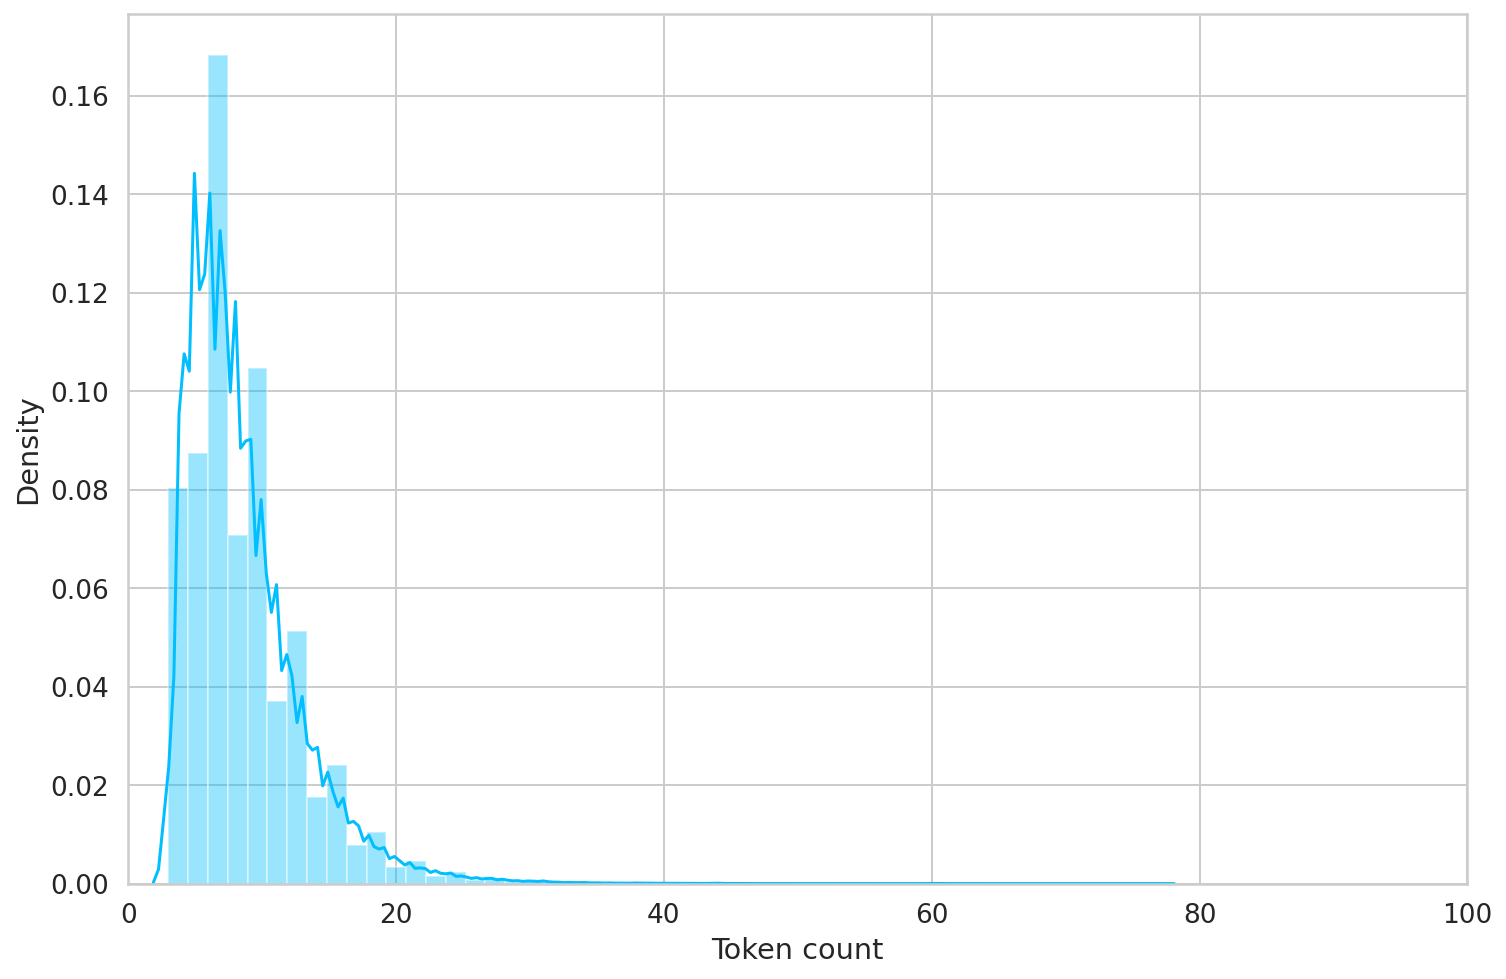

In [25]:
sns.distplot(token_lens)
plt.xlim([0, 100]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 30 tokens, but we'll be on the safe side and choose a maximum length of 50.

In [26]:
MAX_LEN = 50

In [27]:
class ReviewsDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
          review,
          add_special_tokens=True,
          max_length=self.max_len,
          truncation=True,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt'
    )
        return {
          'review_text': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }

Now, lets convert our target to a numeric representation

In [28]:
sentiment_int = {'positive' : 0, 'neutral': 1,  'negative': 2}
df['sentiment_int'] = df.sentiment.map(sentiment_int)
df.head()

,Summary,Score,sentiment,sentiment_int
0,"Be Careful this stuff is addictive, but at the...",5,positive,0
1,FROMM SURF&TURF,5,positive,0
2,Worked Well,4,neutral,1
3,not afraid of subscribe and save,5,positive,0
4,Ginger and cinnamon together,5,positive,0


The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

In [29]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [30]:
df_train.shape, df_val.shape, df_test.shape

((179995, 4), (10000, 4), (10000, 4))

We also need to create a couple of data loaders. Here's a helper function to do

In [31]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = ReviewsDataset(
    reviews=df.Summary.to_numpy(),
    targets=df.sentiment_int.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

    return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
    )

In [32]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from our training data loader:

In [33]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [34]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 50])
torch.Size([16, 50])
torch.Size([16])


**Sentiment Classification with BERT and Hugging Face**  
There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task we might want to use BertForSequenceClassification, BertForQuestionAnswering or something else.

We'll use the basic BertModel and build our sentiment classifier on top of it. Let's load the model:

In [35]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

And try to use it on the encoding of our sample text:

In [36]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

The last_hidden_state is a sequence of hidden states of the last layer of the model. Obtaining the pooled_output is done by applying the BertPooler on last_hidden_state:

In [37]:
bert_model.config.hidden_size

768

We can use all of this knowledge to create a classifier that uses the BERT model:

In [38]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
    )
        output = self.drop(pooled_output)
        return self.out(output)

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [39]:
model = SentimentClassifier(len(sentiment_int))
model = model.to(device)

We'll move the example batch of our training data to the GPU:

In [40]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 50])
torch.Size([16, 50])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [41]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4823, 0.2009, 0.3168],
        [0.4060, 0.1263, 0.4677],
        [0.4781, 0.1222, 0.3997],
        [0.5197, 0.0693, 0.4111],
        [0.4410, 0.1655, 0.3935],
        [0.3660, 0.1596, 0.4745],
        [0.3917, 0.1621, 0.4463],
        [0.3875, 0.1628, 0.4497],
        [0.3530, 0.0995, 0.5475],
        [0.4403, 0.1428, 0.4170],
        [0.4303, 0.1954, 0.3743],
        [0.3666, 0.1235, 0.5099],
        [0.4987, 0.1121, 0.3892],
        [0.2594, 0.2360, 0.5046],
        [0.3110, 0.1006, 0.5884],
        [0.6109, 0.0985, 0.2907]], grad_fn=<SoftmaxBackward>)

Training
To reproduce the training procedure from the BERT paper, we'll use the AdamW optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [42]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.NLLLoss().to(device)

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

1. Batch size: 16, 32
2. Learning rate (Adam): 5e-5, 3e-5, 2e-5
3. Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Let's continue with writing a helper function for training our model for one epoch:

In [43]:
def train_epoch(
      model,
      data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      n_examples
    ):
    
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:   
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using clip_gradnorm.

Let's write another one that helps us evaluate the model on a given data loader:

In [44]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:        
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
              )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

    print(f'Train loss {train_loss}')

    val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/5
----------


Note that we're storing the state of the best model, indicated by the highest validation accuracy.

We can look at the training vs validation accuracy:

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
# plt.ylim([0, 1])

**Evaluation**  
So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

We'll define a helper function to get the predictions from our model:

In [ ]:
def get_predictions(model, data_loader):

    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
    _, preds = torch.max(outputs, dim=1)

    probs = F.softmax(outputs, dim=1)

    review_texts.extend(texts)
    predictions.extend(preds)
    prediction_probs.extend(probs)
    real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred))